# Why MLPs Struggle with Image Data

**Deep Learning - University of Vermont**

---

In this notebook, we are going to explore a fundamental question in Deep Learning: **Why don't we just use simple Neural Networks (MLPs) for everything?**

We will take a hands-on approach to see the limitations of Multi-Layer Perceptrons (MLPs) when applied to image data. Together, we will:
1.  **Build an MLP** from scratch.
2.  **Train it** on the Fashion MNIST dataset.
3.  **Push it to its limits** by increasing the image resolution.

By the end of this, you will see exactly why the parameter count explodes and why we need a better solution

## 1. Historical Context

> Before deep learning took off, computer vision relied heavily on hand-crafted features. But researchers asked: *Could neural networks learn features directly from raw pixels?*

Early attempts using MLPs (Multi-Layer Perceptrons) revealed a fundamental **scalability struggle**. While they worked for small digits (like MNIST), they couldn't handle the complexity of real-world photography.

### The Core Problem

MLPs treat images as flat vectors. This means:
- **Every pixel** must connect to **every neuron** in the first hidden layer.
- This creates a massive number of connections (parameters).
- As image resolution increases, the parameter count explodes!

## 2. The Architecture: A Standard MLP

Let's look at the standard MLP architecture we will be using for image classification. 

**The Setup:**
We take an image, flatten it into a long list of numbers (vectors), and pass it through two hidden layers before predicting the class.


##  MLP Architecture for Image Classification

Let's look at a standard MLP architecture for image classification.

**Architecture:**
```
Input (W × H × C pixels, flattened)
  ↓
FC1: 1,000 neurons
  ↓ ReLU
FC2: 1,000 neurons  
  ↓ ReLU
Output: N classes
```

**Parameter Formula (weights only):**

$$\text{Parameters} = (W \times H \times C) \times 1000 + 1000 \times 1000 + 1000 \times N$$



### Fashion MNIST Classification (MLP)
Here is the breakdown of parameters for a standard 28x28 image. Notice how quickly they add up!

| Layer | Calculation | Parameters |
| :--- | :--- | :--- |
| **Input** | 28 × 28 × 1 | 784 pixels |
| **FC1** | 784 × 1,000 | 784,000 |
| **FC2** | 1,000 × 1,000 | 1,000,000 |
| **Out** | 1,000 × 10 | 10,000 |
| **Total** | | **~1.79 Million** |

That's nearly **1.8 million numbers** the computer has to learn just for tiny, blurry images!

## 3. Setup: Defining a Flexible MLP

To demonstrate the scalability issue, we need an MLP that can handle different input sizes. We'll define a class `FlexibleMLP` that takes the input dimension as an argument.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

# Define the Neural Network Class
# We are renaming this to just 'MLP' because it represents a standard Multi-Layer Perceptron.
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=1000, output_dim=10):
        """
        Initializes the MLP.
        
        Args:
            input_dim (int): The number of input pixels (e.g., 784 for 28x28).
            hidden_dim (int): The number of neurons in the hidden layers.
            output_dim (int): The number of classes to predict (10 for FashionMNIST).
        """
        super(MLP, self).__init__()
        
        # 1. Flatten Layer
        # Images come in as 2D grids (Height x Width). 
        # MLPs can't handle grids; they need a flat list. 
        # This layer unrolls the image into a single long vector.
        self.flatten = nn.Flatten()
        
        # 2. First Fully Connected Layer (FC1)
        # This connects every single input pixel to every single hidden neuron.
        # This is where the massive parameter explosion happens!
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        
        # 3. Activation Function (ReLU)
        # Without this, our network would just be one big linear regression.
        # ReLU allows it to learn complex, non-linear patterns.
        self.relu = nn.ReLU()
        
        # 4. Second Fully Connected Layer (FC2)
        # Adds more depth to the network.
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        # 5. Output Layer (FC3)
        # Compresses the information down to 'output_dim' scores (one for each class).
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        The Forward Pass: This is the path data takes through the network.
        """
        x = self.flatten(x)     # Flatten the image
        x = self.fc1(x)         # Pass through first layer
        x = self.relu(x)        # Apply activation
        x = self.fc2(x)         # Pass through second layer
        x = self.relu(x)        # Apply activation
        x = self.fc3(x)         # Output scores
        return x

### Training Helper Function

Since we will be training the model multiple times with different image sizes, let's define a helper function to handle the training loop. This keeps our code clean and reusable.

In [39]:
def train_epoch(model, dataloader, criterion, optimizer):
    """
    Runs one epoch of training.
    Returns: Average Training Loss
    """
    model.train() # Put model in training mode
    running_loss = 0.0
    
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    return running_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    """
    Evaluates the model on validation data.
    Returns: Average Loss, Accuracy
    """
    model.eval() # Set to evaluation mode (disables dropout, etc.)
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): # Don't track gradients during validation
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

## 4. Experiment 1: Standard Resolution (28x28)

First, let's run the baseline. This is the standard size for Fashion MNIST.

We will:
1. Resize images to 28x28 (standard).
2. Create the MLP with input size $28 \times 28 = 784$.
3. Train for 1 epoch and measure time.

In [40]:
print("\n--- Experiment 1: Standard 28x28 Images ---")

# 1. Prepare Data
transform_28 = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_28)

# Split: 1000 for training, 200 for validation (keeping it small for speed)
train_set = torch.utils.data.Subset(full_dataset, range(1000))
val_set = torch.utils.data.Subset(full_dataset, range(1000, 1200))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# 2. Create Model
input_features_28 = 28 * 28
model_28 = MLP(input_dim=input_features_28)

# 3. Check Size
params_28 = sum(p.numel() for p in model_28.parameters())
print(f"Input Features: {input_features_28:,}")
print(f"Total Parameters: {params_28:,}")

# 4. Train
optimizer = optim.SGD(model_28.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
epochs = 5
print(f"Training for {epochs} epochs...")

for epoch in range(epochs):
    train_loss = train_epoch(model_28, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model_28, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

time_28 = time.time() - start_time
print(f"Training Time: {time_28:.2f} seconds")


--- Experiment 1: Standard 28x28 Images ---
Input Features: 784
Total Parameters: 1,796,010
Training for 5 epochs...
Epoch 1/5 | Train Loss: 2.1723 | Val Loss: 2.0286 | Val Acc: 44.50%
Epoch 2/5 | Train Loss: 1.9055 | Val Loss: 1.7448 | Val Acc: 48.00%
Epoch 3/5 | Train Loss: 1.6167 | Val Loss: 1.4663 | Val Acc: 50.50%
Epoch 4/5 | Train Loss: 1.3642 | Val Loss: 1.2700 | Val Acc: 65.00%
Epoch 5/5 | Train Loss: 1.1614 | Val Loss: 1.1025 | Val Acc: 63.50%
Training Time: 1.34 seconds


## 5. Experiment 2: Increased Resolution (64x64)

Now, let's pretend we have slightly better quality images. We resize inputs to 64x64.

Notice how we have to create a **new model** with a much larger input dimension ($64 \times 64 = 4096$).

In [41]:
print("\n--- Experiment 2: Increased Resolution (64x64) ---")

# 1. Prepare Data
transform_64 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_64)
train_set = torch.utils.data.Subset(full_dataset, range(1000))
val_set = torch.utils.data.Subset(full_dataset, range(1000, 1200))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# 2. Create Model
input_features_64 = 64 * 64
model_64 = MLP(input_dim=input_features_64)

# 3. Check Size
params_64 = sum(p.numel() for p in model_64.parameters())
print(f"Input Features: {input_features_64:,}")
print(f"Total Parameters: {params_64:,}")

# 4. Train
optimizer = optim.SGD(model_64.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
epochs = 5
print(f"Training for {epochs} epochs...")

for epoch in range(epochs):
    train_loss = train_epoch(model_64, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model_64, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

time_64 = time.time() - start_time
print(f"Training Time: {time_64:.2f} seconds")


--- Experiment 2: Increased Resolution (64x64) ---
Input Features: 4,096
Total Parameters: 5,108,010
Training for 5 epochs...
Epoch 1/5 | Train Loss: 2.0282 | Val Loss: 1.7054 | Val Acc: 44.00%
Epoch 2/5 | Train Loss: 1.4841 | Val Loss: 1.2960 | Val Acc: 52.50%
Epoch 3/5 | Train Loss: 1.1343 | Val Loss: 1.0154 | Val Acc: 65.50%
Epoch 4/5 | Train Loss: 0.9239 | Val Loss: 0.9035 | Val Acc: 67.50%
Epoch 5/5 | Train Loss: 0.8251 | Val Loss: 0.8002 | Val Acc: 67.50%
Training Time: 2.11 seconds


## 6. Experiment 3: Even Higher Resolution (128x128)

Let's double the resolution again. We are still far from "HD" (1920x1080), but watch what happens to the model size.

Input dimension is now $128 \times 128 = 16,384$.

In [42]:
print("\n--- Experiment 3: Even Higher (128x128) ---")

# 1. Prepare Data
transform_128 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_128)
train_set = torch.utils.data.Subset(full_dataset, range(1000))
val_set = torch.utils.data.Subset(full_dataset, range(1000, 1200))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# 2. Create Model
input_features_128 = 128 * 128
model_128 = MLP(input_dim=input_features_128)

# 3. Check Size
params_128 = sum(p.numel() for p in model_128.parameters())
print(f"Input Features: {input_features_128:,}")
print(f"Total Parameters: {params_128:,}")

# 4. Train
optimizer = optim.SGD(model_128.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
epochs = 5
print(f"Training for {epochs} epochs...")

for epoch in range(epochs):
    train_loss = train_epoch(model_128, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model_128, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

time_128 = time.time() - start_time
print(f"Training Time: {time_128:.2f} seconds")


--- Experiment 3: Even Higher (128x128) ---
Input Features: 16,384
Total Parameters: 17,396,010
Training for 5 epochs...
Epoch 1/5 | Train Loss: 1.6924 | Val Loss: 1.2266 | Val Acc: 57.50%
Epoch 2/5 | Train Loss: 1.0126 | Val Loss: 1.0522 | Val Acc: 63.50%
Epoch 3/5 | Train Loss: 0.8016 | Val Loss: 0.7884 | Val Acc: 66.50%
Epoch 4/5 | Train Loss: 0.7023 | Val Loss: 0.9247 | Val Acc: 63.50%
Epoch 5/5 | Train Loss: 0.6540 | Val Loss: 0.9457 | Val Acc: 63.00%
Training Time: 4.01 seconds


## 7. The "HD" Struggle: 1024x1024 Images

What if we tried a high-definition image? A 1024x1024 image isn't even that big by modern standards (your phone takes much larger photos).

Let's look at the numbers for a hypothetical 1024x1024 input:

| Metric | Value |
| :--- | :--- |
| **Input Features** | 1,048,576 pixels |
| **First Layer Weights** | 1,048,576,000 (~1 Billion) |
| **Memory for Weights (float32)** | **4.19 GB** |

That's just for *one layer's weights*. We haven't counted the gradients (another 4GB), the optimizer states (another 8GB), or the activations. 

This simple network would crash most consumer GPUs!


--- Scalability Summary ---
Resolution  Input Pixels  Parameters  Training Time (s)
     28x28           784     1796010           1.342244
     64x64          4096     5108010           2.105086
   128x128         16384    17396010           4.009013


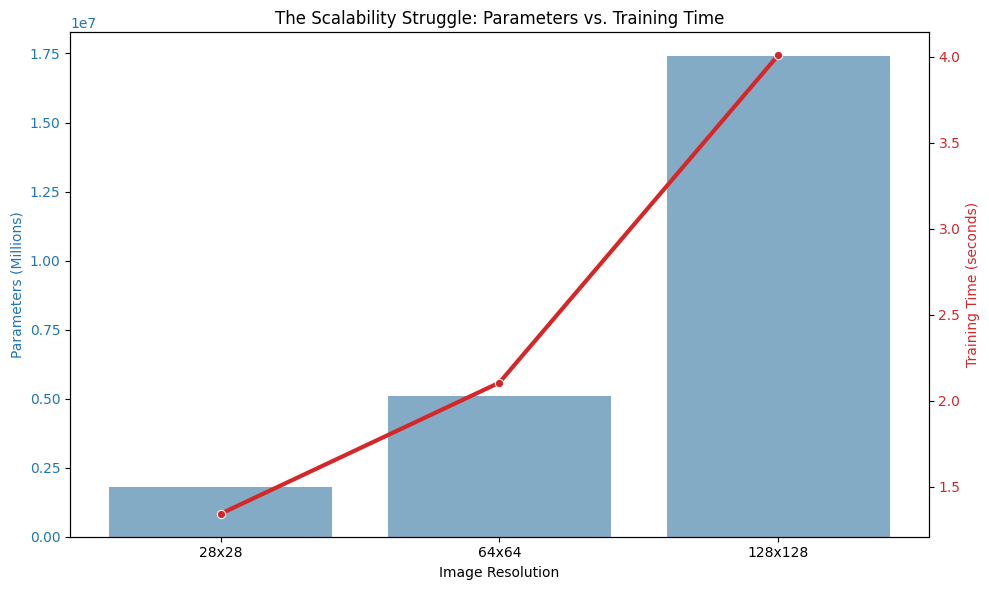

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data Collection
data = {
    'Resolution': ['28x28', '64x64', '128x128'],
    'Input Pixels': [28*28, 64*64, 128*128],
    'Parameters': [params_28, params_64, params_128],
    'Training Time (s)': [time_28, time_64, time_128]
}

df = pd.DataFrame(data)

# Display Table
print("\n--- Scalability Summary ---")
print(df.to_string(index=False))

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Image Resolution')
ax1.set_ylabel('Parameters (Millions)', color=color)
sns.barplot(x='Resolution', y='Parameters', data=df, ax=ax1, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Time
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time (seconds)', color=color)
sns.lineplot(x='Resolution', y='Training Time (s)', data=df, ax=ax2, color=color, marker='o', linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('The Scalability Struggle: Parameters vs. Training Time')
plt.tight_layout()
plt.show()

## 8. Why This Matters: The Scalability Problem

Let's summarize why MLPs struggles for images. Look at the difference between a small thumbnail and a standard 2MP photo:

| Problem | 64×64 Image | 2000×2000 Image |
| :--- | :--- | :--- |
| **Parameters** | ~13 Million | ~12 Billion |
| **Memory (Training)** | ~0.15 GB | ~135 GB |
| **Practical?** | Yes | **No** |

### Key Issues
1.  **Memory**: 12 billion parameters × 4 bytes × 3 (gradients + optimizer) ≈ **135 GB**. This is impossible for most hardware.
2.  **Overfitting**: With only 10,000 training images, having 12 billion parameters means you have ~1.2 million parameters *per example*. The model will just memorize the data instead of learning.
3.  **No Spatial Awareness**: MLPs treat adjacent pixels as independent features. They don't understand that pixel (0,0) is next to pixel (0,1). This is a huge waste of information!

## 9. The Solution: Convolutional Neural Networks

The experiments above show that MLPs do not scale well. As image size increases linearly, the parameter count (and memory usage) grows quadratically with the image dimension (width * height).

**Convolutional Neural Networks (CNNs)** solve this by:
1.  **Local Connectivity**: Neurons only look at small patches of the image.
2.  **Parameter Sharing**: The same filter is used across the entire image.

In the next notebook, we will implement a CNN and see that it can handle larger images with a fraction of the parameters!